In [14]:
# Install the Google Generative AI library
!pip install -q -U google-generativeai

# Import necessary libraries
import google.generativeai as genai
import json
import pandas as pd
from kaggle_secrets import UserSecretsClient
from sklearn.metrics import classification_report, accuracy_score
from tqdm.notebook import tqdm # For a nice progress bar

# --- Configuration ---
# Set up the Gemini API Key from Kaggle Secrets
try:
    user_secrets = UserSecretsClient()
    GEMINI_API_KEY = user_secrets.get_secret("GEMINI_API_KEY")
    genai.configure(api_key=GEMINI_API_KEY)
    print("Gemini API Key configured successfully.")
except Exception as e:
    print("ERROR: Could not get Gemini API Key. Please ensure it is set in Kaggle Secrets.")
    print(e)

# Initialize the Gemini model
# We use a recent model capable of following complex JSON instructions.
model = genai.GenerativeModel('gemini-2.5-flash')

print("Setup complete.")

Gemini API Key configured successfully.
Setup complete.


In [15]:
BATCH_MASTER_PROMPT_TEMPLATE = """
I. ROLE AND GOAL: You are an expert AI data labeler. Your goal is to accurately label a BATCH of records provided as a JSON array, according to the specified schema and rules of each of the JSON sample in the JSON array.

II. TASK DESCRIPTION: You will be given a JSON array where each object is a summary of a political Vietnamese newspaper page. For EACH object in the array, you must perform the following tasks. 
1. Extract the trigger from the summary of the object ONLY.
2. Label the event type of summary. Each of the summary has only 1 main event type. The allowed event types are defined in section IV.
3. Then, extract the subject, location and time of that the event happens from the summary. Remember, just extract from the summary ONLY.

III. OUTPUT FORMAT: Your response MUST be a single, valid JSON array. The array must contain the same number of objects as the input array, and they must be in the same order. Each object in your output array should ONLY contain the fields: `id`, 'url', 'title', 'publish_date', 'summary', `event_type`, `trigger`, `arg_subject`, `arg_time`, `arg_location`. Each of the JSON object 'id', 'url', 'title', 'publish_date', 'summary' fields at output is the same as each of that JSON object of those respective fields at the input.
**CRITICAL RULE: If the input array contains N objects, your output array MUST contain EXACTLY N objects. Do not add, omit, or duplicate any objects.**

IV. ALLOWED EVENT TYPES: Legislation, Cooperation, Visiting, Meeting, Celebration, Proposal, Statement, Government Formation, Condolence, Commemoration, Publication, Inspection, Diplomatic Reception, Recognition.

V. RULES
These rules govern how to choose between similar or overlapping event types. Always apply these principles.

Rule of Specificity: Always choose the most specific and descriptive event type. If an event is a Meeting about creating a law, the correct type is Legislation, not Meeting, because it describes the meeting's specific purpose.

Focus on the Core Action: Identify the primary action in the text. For example, A Head of State might be on a week-long Visiting trip, but if the text only describes the moment they are formally received by their counterpart (tiếp), the event is Diplomatic Reception.

Differentiate Time Focus: For example, Commemoration is about remembering or marking a past event (anniversaries, historical figures). And, Celebration is about a present positive event (a project completion, a new appointment, sending congratulations).

Differentiate Communication Intent: Statement is informative (reporting facts, clarifying a position). Proposal is directive (suggesting or demanding future action). Recognition is evaluative (praising or acknowledging a positive quality).

Other: If the trigger you find don't align with the common triggers of each event type, you have to decide which event type that summary belongs to first. Then, find the trigger. Only after the trigger(s) and the event type had been decided, you will find the rest of the required argument.

VI. LABEL SCHEMA AND DEFINITIONS
Here are the definitions for each event type.
1. Legislation
Definition: An event focused on the creation, discussion, enactment, amendment, or high-level enforcement of formal rules (laws, decrees, policies, resolutions) by an authoritative body.
Some Common Triggers: Luật (Law), Nghị quyết (Resolution), Nghị định (Decree), Chính sách (Policy), ban hành (issue), thông qua (pass), sửa đổi (amend), cho ý kiến (give opinion), xem xét (review), dự thảo (draft), thẩm tra (verify).

2. Celebration
Definition: An event marking a joyous occasion, an achievement, or extending congratulations for a current positive event. This includes opening ceremonies and congratulatory messages.
Some Common Triggers: chúc mừng (congratulate), khánh thành (inaugurate), lễ (ceremony), hoàn thành (complete), phê chuẩn (approve an appointment).

3. Cooperation
Definition: An event involving two or more distinct parties (nations, organizations, companies) working together, discussing their relationship, or formalizing a partnership.
Some Common Triggers: hợp tác (cooperate), quan hệ đối tác (partnership), song phương (bilateral), giữa hai nước (between two countries), củng cố (strengthen ties).

4. Visiting
Definition: An event centered on the physical travel of a person or delegation to a specific location for an official or ceremonial purpose. This covers the entire duration of the trip.
Some Common Triggers: chuyến thăm (visit/trip), đến (arrive), về đến (return to), công du (official tour).

5. Meeting
Definition: An event where one or more individuals formally gather to discuss issues, hold talks, or attend an event as participants. If the meeting's specific purpose fits another category (like Legislation), use that category instead (see Rule of Specificity).
Some Common Triggers: họp (meeting), hội nghị (conference), hội đàm (talks), dự (attend), tham dự (participate).
6. Proposal
Definition: An event where an entity or official puts forward a suggestion, a directive, a plan, or a new idea for others to consider or implement. It is about future action.
Some Common Triggers: đề nghị (propose), yêu cầu (request/demand), chia sẻ thông điệp (share a message), định hướng (orient/direct), chỉ đạo (direct).

7. Statement
Definition: A one-way communication event where an entity or official informs, clarifies a position, or makes a public announcement. It is about reporting information.
Some Common Triggers: phát biểu (to state), thông tin (to inform), cho biết (to let know), nhấn mạnh (to emphasize), khuyến cáo (to recommend/warn), trả lời phỏng vấn (to answer an interview).

8. Government Formation
Definition: An event related to the appointment, election, dismissal, or transfer of individuals into or out of official government or party positions.
Some Common Triggers: bổ nhiệm (appoint), bầu (elect), miễn nhiệm (dismiss), điều động (transfer), phê chuẩn (ratify an appointment).

9. Condolence
Definition: An event expressing sympathy, offering aid, or directing recovery efforts in response to a tragedy, disaster, or death.
Some Common Triggers: thăm hỏi (inquire/visit in sympathy), chia buồn (condolence), thiệt mạng (loss of life), tai nạn (accident), tử vong (death), khắc phục hậu quả (overcome consequences).

10. Commemoration
Definition: An event that marks or remembers a significant past event, anniversary, or historical figure.
Some Common Triggers: kỷ niệm (anniversary), tưởng nhớ (commemorate/remember), dâng hương (offer incense), đánh dấu X năm (mark X years), lưu niệm (souvenir/memorial).

11. Publication
Definition: An event where a written work, speech, or digital resource (like a website or report) is officially released or made available to the public.
Some Common Triggers: bài viết (article), giới thiệu (introduce), công bố (publish), xuất bản (publish), khai trương trang tin (launch a news site), toàn văn (full text).

12. Inspection
Definition: An event where an official or an authoritative body examines, reviews, or assesses a project, location, or the conduct of individuals/organizations.
Some Common Triggers: kiểm tra (inspect), khảo sát (survey), giám sát (supervise), xem xét kỷ luật (review for discipline), thanh tra (inspect).

13. Diplomatic Reception
Definition: A formal meeting where a host (e.g., a head of state) receives a guest (e.g., a foreign official, a business leader). The key action is the reception itself. This is more specific than a general Meeting or Visiting.
Some Common Triggers: tiếp (to receive), hội kiến (to have an audience with), chào (to greet).

14. Recognition
Definition: An event or statement that primarily serves to praise, acknowledge the positive status, or recognize the achievements or qualities of an entity. It is often abstract and focuses on evaluation rather than a discrete action.
Some Common Triggers: (Phrases of praise) đánh giá cao (highly appreciate), ghi nhận (recognize), là một điểm sáng (is a bright spot), thể hiện sự ủng hộ (express support), tin cậy (trustworthy).

VII. EXAMPLES OF DATA IN EACH EVENT TYPE: Here are some examples of correctly labeled data:
** Data for Legislation event type **
{
"id": 1,
"url": "https://baochinhphu.vn/ban-hanh-vi-tri-viec-lam-cua-dai-bieu-quoc-hoi-hoat-dong-chuyen-trach-o-trung-uong-102240906163814921.htm",
"title": "Ban hành vị trí việc làm của đại biểu Quốc hội hoạt động chuyên trách ở Trung ương",
"publish_date": "06/09/2024 16:44",
"summary": "Ủy ban Thường vụ Quốc hội có Nghị quyết số 1158/NQ-UBTVQH15 ban hành vị trí việc làm của đại biểu Quốc hội hoạt động chuyên trách ở Trung ương và cán bộ thuộc thẩm quyền quản lý của Ủy ban Thường vụ Quốc hội.",
"event_type": "Legislation",
"trigger": "ban hành",
"arg_subject": "Ủy ban Thường vụ Quốc hội",
"arg_time": "NULL",
"arg_location": "NULL"
}
{
"id": 191,
"url": "https://baochinhphu.vn/can-thiet-xay-dung-va-ban-hanh-luat-dien-luc-sua-doi-102240819161735758.htm",
"title": "Cần thiết xây dựng và ban hành Luật Điện lực (sửa đổi)",
"publish_date": "19/08/2024 16:26",
"summary": "Tiếp tục chương trình Phiên họp thứ 36, chiều 19/8, Ủy ban Thường vụ Quốc hội cho ý kiến về dự án Luật Điện lực (sửa đổi).",
"event_type": "Legislation",
"trigger": "cho ý kiến, Luật",
"arg_subject": "Ủy ban Thường vụ Quốc hội",
"arg_time": "chiều 19/8",
"arg_location": "NULL"
}
{
"id": 268,
"url": "https://baochinhphu.vn/bao-dam-su-thong-nhat-cua-du-thao-luat-sua-doi-bo-sung-mot-so-dieu-cua-luat-duoc-voi-cac-luat-co-lien-quan-102240812145724674.htm",
"title": "Bảo đảm sự thống nhất của dự thảo Luật sửa đổi, bổ sung một số điều của Luật Dược với các luật có liên quan",
"publish_date": "12/08/2024 14:57",
"summary": "Cơ quan soạn thảo và cơ quan thẩm tra Dự thảo Luật sửa đổi, bổ sung một số điều của Luật Dược cần tiếp tục rà soát để bảo đảm thống nhất với các luật có liên quan và điều ước quốc tế mà Việt Nam là thành viên, đồng thời rà soát các thuật ngữ, giải thích từ ngữ để làm tường minh các nội dung;…",
"event_type": "Legislation",
"trigger": "thẩm tra, Dự thảo Luật, sửa đổi, bổ sung",
"arg_subject": "Cơ quan soạn thảo, cơ quan thẩm tra Dự thảo Luật",
"arg_time": "NULL",
"arg_location": "NULL"
}
** Data for Celebration event type **
{
"id": 70,
"url": "https://baochinhphu.vn/chum-anh-le-khanh-thanh-du-an-duong-day-500-kv-mach-3-quang-trach-pho-noi-102240829095739843.htm",
"title": "Chùm ảnh: Lễ khánh thành dự án đường dây 500 kV mạch 3 Quảng Trạch-Phố Nối",
"publish_date": "29/08/2024 09:58",
"summary": "Lễ khánh thành dự án đường dây 500 kV mạch 3 do Tập đoàn Điện lực Việt Nam (EVN) và Tổng công ty Truyền tải điện Quốc gia (EVNNPT) tổ chức vào sáng 29/8 theo hình trực tiếp kết hợp trực tuyến với điểm cầu chính diễn ra tại trạm biến áp 500 kV Phố Nối (Hưng Yên), kết nối trực tuyến đến 8 điểm cầu thuộc 8 tỉnh nơi có dự án đi qua.",
"event_type": "Celebration",
"trigger": "Lễ khánh thành, tổ chức",
"arg_subject": "Tập đoàn Điện lực Việt Nam (EVN) và Tổng công ty Truyền tải điện Quốc gia (EVNNPT)",
"arg_time": "sáng 29/8",
"arg_location": "trạm biến áp 500 kV Phố Nối (Hưng Yên)"
}
{
"id": 198,
"url": "https://baochinhphu.vn/thu-tuong-pham-minh-chinh-gui-thu-chuc-mung-thu-tuong-vuong-quoc-thai-lan-102240819095113974.htm",
"title": "Thủ tướng Phạm Minh Chính gửi thư chúc mừng Thủ tướng Vương quốc Thái Lan",
"publish_date": "19/08/2024 09:44",
"summary": "Ngày 18/8/2024, nhân dịp bà Paetongtarn Shinawatra được Nhà Vua Thái Lan phê chuẩn làm Thủ tướng Vương quốc Thái Lan, Thủ tướng Chính phủ Phạm Minh Chính đã gửi Thư chúc mừng./.",
"event_type": "Celebration",
"trigger": "dịp, Nhà Vua, phê chuẩn, gửi Thư chúc mừng",
"arg_subject": "Thủ tướng Chính phủ Phạm Minh Chính",
"arg_time": "Ngày 18/8/2024",
"arg_location": "NULL"
}
{
"id": 330,
"url": "https://baochinhphu.vn/tong-bi-thu-chu-tich-nuoc-trung-quoc-tap-can-binh-chuc-mung-tong-bi-thu-chu-tich-nuoc-to-lam-102240803173156935.htm",
"title": "Tổng Bí thư, Chủ tịch nước Trung Quốc Tập Cận Bình chúc mừng Tổng Bí thư, Chủ tịch nước Tô Lâm",
"publish_date": "03/08/2024 17:20",
"summary": "Nhân dịp đồng chí Tô Lâm, Ủy viên Bộ Chính trị, Chủ tịch nước được bầu giữ chức Tổng Bí thư Ban Chấp hành Trung ương Đảng Cộng sản Việt Nam, Tổng Bí thư, Chủ tịch nước Trung Quốc Tập Cận Bình đã gửi điện chúc mừng Tổng Bí thư, Chủ tịch nước Tô Lâm. Cổng Thông tin điện tử Chính phủ trân trọng giới thiệu Điện mừng:",
"event_type": "Celebration",
"trigger": "gửi điện chúc mừng",
"arg_subject": "Tổng Bí thư, Chủ tịch nước Trung Quốc Tập Cận Bình",
"arg_time": "NULL",
"arg_location": "NULL"
}
** Data for Cooperation event type **
{
"id": 361,
"url": "https://baochinhphu.vn/viet-nam-an-do-trao-doi-9-van-kien-hop-tac-quan-trong-102240801163334881.htm",
"title": "Việt Nam, Ấn Độ trao đổi 9 văn kiện hợp tác quan trọng",
"publish_date": "01/08/2024 16:41",
"summary": "Trưa 1/8, tại Thủ đô New Delhi, sau khi hội đàm, Thủ tướng Phạm Minh Chính và Thủ tướng Ấn Độ Narendra Modi đã chứng kiến lễ trao đổi các văn kiện hợp tác quan trọng giữa hai nước.",
"event_type": "Cooperation",
"trigger": "hợp tác, giữa hai nước",
"arg_subject": "Thủ tướng Phạm Minh Chính, Thủ tướng Ấn Độ Narendra Modi",
"arg_time": "Trưa 1/8",
"arg_location": "Thủ đô New Delhi"
}
{
"id": 229,
"url": "https://baochinhphu.vn/dai-su-hung-ba-chuyen-tham-cua-tong-bi-thu-chu-tich-nuoc-to-lam-cung-co-hon-nua-tin-cay-chinh-tri-102240816114642982.htm",
"title": "Đại sứ Hùng Ba: Chuyến thăm của Tổng Bí thư, Chủ tịch nước Tô Lâm củng cố hơn nữa tin cậy chính trị",
"publish_date": "16/08/2024 11:55",
"summary": "Trước thềm chuyến thăm cấp Nhà nước của Tổng Bí thư, Chủ tịch nước Tô Lâm và Phu nhân đến nước Cộng hòa nhân dân Trung Hoa từ ngày 18 - 20/8/2024, Đại sứ Trung Quốc tại Việt Nam Hùng Ba đã trả lời phỏng vấn báo chí về chuyến thăm này cũng như về quan hệ hợp tác hai Đảng, hai nước:",
"event_type": "Cooperation",
"trigger": "hợp tác",
"arg_subject": "Tổng Bí thư, Chủ tịch nước Tô Lâm",
"arg_time": "từ ngày 18 - 20/8/2024",
"arg_location": "nước Cộng hòa nhân dân Trung Hoa, Việt Nam"
}
{
"id": 246,
"url": "https://baochinhphu.vn/hop-tac-quoc-phong-viet-nam-malaysia-ngay-cang-phat-trien-sau-rong-102240814161111343.htm",
"title": "Hợp tác quốc phòng Việt Nam-Malaysia ngày càng phát triển sâu rộng",
"publish_date": "14/08/2024 16:15",
"summary": "Với khuôn khổ quan hệ đối tác chiến lược, tiềm năng và dư địa hợp tác quốc phòng giữa hai nước Việt Nam và Malaysia còn rất lớn.",
"event_type": "Cooperation",
"trigger": "quan hệ đối tác chiến lược, hợp tác",
"arg_subject": "Việt Nam, Malaysia",
"arg_time": "NULL",
"arg_location": "NULL"
}
** Data for Visiting event type **
{
"id": 31,
"url": "https://baochinhphu.vn/gan-31000-luot-khach-vao-lang-vieng-bac-trong-ngay-2-9-102240902170935787.htm",
"title": "Gần 31.000 lượt khách vào Lăng viếng Bác trong ngày 2/9",
"publish_date": "02/09/2024 17:18",
"summary": "Sáng 2/9/2024, Ban Quản lý Lăng Chủ tịch Hồ Chí Minh đã tổ chức đón tiếp tận tình, chu đáo gần 31.000 lượt khách vào Lăng viếng Bác.",
"event_type": "Visiting",
"trigger": "đón tiếp",
"arg_subject": "Ban Quản lý Lăng Chủ tịch Hồ Chí Minh",
"arg_time": "Sáng 2/9/2024",
"arg_location": "Lăng"
}
{
"id": 179,
"url": "https://baochinhphu.vn/tong-bi-thu-chu-tich-nuoc-to-lam-va-phu-nhan-ket-thuc-tot-dep-chuyen-tham-cap-nha-nuoc-toi-trung-quoc-102240820173438522.htm",
"title": "Tổng Bí thư, Chủ tịch nước Tô Lâm và Phu nhân kết thúc tốt đẹp chuyến thăm cấp Nhà nước tới Trung Quốc",
"publish_date": "20/08/2024 17:33",
"summary": "Chiều 20/8, Tổng Bí thư, Chủ tịch nước Tô Lâm và Phu nhân cùng Đoàn đại biểu cấp cao Việt Nam đã về đến Hà Nội, kết thúc tốt đẹp chuyến thăm cấp Nhà nước tới Cộng hòa Nhân dân Trung Hoa từ ngày 18-20/8, theo lời mời của Tổng Bí thư, Chủ tịch Trung Quốc Tập Cận Bình và Phu nhân.",
"event_type": "Visiting",
"trigger": "chuyến thăm",
"arg_subject": "Tổng Bí thư, Chủ tịch nước Tô Lâm",
"arg_time": "Chiều 20/8, từ ngày 18-20/8",
"arg_location": "Hà Nội, Cộng hòa Nhân dân Trung Hoa"
}
{
"id": 378,
"url": "https://baochinhphu.vn/tong-thong-timor-leste-den-ha-noi-bat-dau-tham-cap-nha-nuoc-toi-viet-nam-102240731194831368.htm",
"title": "Tổng thống Timor-Leste đến Hà Nội, bắt đầu thăm cấp Nhà nước tới Việt Nam",
"publish_date": "31/07/2024 20:19",
"summary": "Chiều tối 31/7, Tổng thống nước Cộng hòa Dân chủ Timor-Leste Jose Ramos-Horta đến Hà Nội, bắt đầu thăm cấp Nhà nước tới Việt Nam từ ngày 31/7 đến 3/8, theo lời mời của Chủ tịch nước Cộng hòa xã hội chủ nghĩa Việt Nam Tô Lâm.",
"event_type": "Visiting",
"trigger": "thăm",
"arg_subject": "Tổng thống nước Cộng hòa Dân chủ Timor-Leste Jose Ramos-Horta",
"arg_time": "Chiều tối 31/7, từ ngày 31/7 đến 3/8",
"arg_location": "Hà Nội, Việt Nam"
}
** Data for Meeting event type **
{
"id": 88,
"url": "https://baochinhphu.vn/quan-triet-sau-sac-3-nguyen-tac-co-ban-trong-viec-xay-dung-van-kien-102240827182136793.htm",
"title": "Quán triệt sâu sắc 3 nguyên tắc cơ bản trong việc xây dựng văn kiện",
"publish_date": "27/08/2024 18:26",
"summary": "Ngày 27/8, tại Trụ sở Trung ương Đảng, Tổng Bí thư, Chủ tịch nước Tô Lâm, Trưởng Tiểu ban Văn kiện Đại hội XIV của Đảng đã chủ trì cuộc họp của Tiểu ban Văn kiện Đại hội XIV của Đảng cho ý kiến vào dự thảo Báo cáo chính trị do Tổ Biên tập xây dựng trên cơ sở Đề cương chi tiết Báo cáo chính trị đã được Hội nghị lần thứ 9, Ban Chấp hành Trung ương Đảng khóa XIII thông qua.",
"event_type": "Meeting",
"trigger": "chủ trì cuộc họp",
"arg_subject": "Tổng Bí thư, Chủ tịch nước Tô Lâm, Trưởng Tiểu ban Văn kiện Đại hội XIV của Đảng",
"arg_time": "Ngày 27/8",
"arg_location": "Trụ sở Trung ương Đảng"
}
{
"id": 71,
"url": "https://baochinhphu.vn/thu-tuong-du-le-khanh-thanh-duong-day-500-kv-mach-3-102240829083006205.htm",
"title": "Thủ tướng dự lễ khánh thành đường dây 500 kV mạch 3",
"publish_date": "29/08/2024 08:30",
"summary": "Sáng 29/8, tại tỉnh Hưng Yên, Thủ tướng Phạm Minh Chính dự lễ khánh thành Dự án đường dây 500 kV mạch 3 từ Quảng Trạch (Quảng Bình) đến Phố Nối (Hưng Yên).",
"event_type": "Meeting",
"trigger": "dự lễ",
"arg_subject": "Thủ tướng Phạm Minh Chính",
"arg_time": "Sáng 29/8",
"arg_location": "tỉnh Hưng Yên"
}
{
"id": 45,
"url": "https://baochinhphu.vn/da-nang-se-but-pha-toan-dien-tu-nghi-quyet-136-102240831172749171.htm",
"title": "Đà Nẵng sẽ bứt phá toàn diện từ Nghị quyết 136",
"publish_date": "31/08/2024 17:55",
"summary": "Tại Hội nghị quán triệt, triển khai Nghị quyết số 136/2024/QH15 của Quốc hội về tổ chức chính quyền đô thị và thí điểm một số cơ chế, chính sách đặc thù phát triển thành phố Đà Nẵng tổ chức chiều 31/8, các đại biểu và lãnh đạo TP. Đà Nẵng khẳng định đây một dấu mốc quan trọng, thể hiện sự quan tâm sâu sắc của Đảng, Quốc hội và Chính phủ đối với TP. Đà Nẵng.",
"event_type": "Meeting",
"trigger": "Hội nghị quán triệt, triển khai Nghị quyết số 136/2024/QH15 của Quốc hội",
"arg_subject": "các đại biểu và lãnh đạo TP. Đà Nẵng",
"arg_time": "chiều 31/8",
"arg_location": "Hội nghị quán triệt"
}
{
"id": 27,
"url": "https://baochinhphu.vn/tong-bi-thu-chu-tich-nuoc-to-lam-dien-dam-voi-chu-tich-dang-dan-chu-tu-do-nhat-ban-102240903191050754.htm",
"title": "Tổng Bí thư, Chủ tịch nước Tô Lâm điện đàm với Chủ tịch Đảng Dân chủ Tự do Nhật Bản",
"publish_date": "03/09/2024 19:32",
"summary": "Chiều 3/9, tại Trụ sở Trung ương Đảng, Tổng Bí thư, Chủ tịch nước Tô Lâm đã hội đàm trực tuyến cấp cao với Chủ tịch Đảng Dân chủ Tự do, Thủ tướng Nhật Bản Kishida Fumio.",
"event_type": "Meeting",
"trigger": "hội đàm",
"arg_subject": "Tổng Bí thư, Chủ tịch nước Tô Lâm",
"arg_time": "Chiều 3/9",
"arg_location": "Trụ sở Trung ương Đảng"
}
{
"id": 14,
"url": "https://baochinhphu.vn/pho-thu-tuong-le-thanh-long-du-khai-giang-trao-hoc-bong-cho-hoc-sinh-tinh-hoa-binh-102240905122920201.htm",
"title": "Phó Thủ tướng Lê Thành Long dự khai giảng, trao học bổng cho học sinh tỉnh Hòa Bình",
"publish_date": "05/09/2024 14:04",
"summary": "Hôm nay, 5/9, Phó Thủ tướng Lê Thành Long đã dự lễ khai giảng, tặng máy tính, xe đạp, học bổng cho học sinh của Trường Tiểu học và THCS Tuân Đạo, huyện Lạc Sơn (tỉnh Hòa Bình), địa phương có trên 91% dân số là người dân tộc Mường.",
"event_type": "Meeting",
"trigger": "dự lễ khai giảng, tặng máy tính, xe đạp, học bổng",
"arg_subject": "Phó Thủ tướng Lê Thành Long",
"arg_time": "Hôm nay, 5/9",
"arg_location": "Trường Tiểu học và THCS Tuân Đạo, huyện Lạc Sơn (tỉnh Hòa Bình)"
}
** Data for Proposal event type **
{
"id": 150,
"url": "https://baochinhphu.vn/thu-tuong-pham-minh-chinh-chia-se-3-thong-diep-3-dinh-huong-3-trong-tam-voi-nguoi-viet-nam-o-nuoc-ngoai-102240822124016417.htm",
"title": "Thủ tướng Phạm Minh Chính chia sẻ 3 thông điệp, 3 định hướng, 3 trọng tâm với người Việt Nam ở nước ngoài",
"publish_date": "22/08/2024 12:40",
"summary": "Sáng 22/8, dự phiên toàn thể 'Diễn đàn Trí thức và chuyên gia Việt Nam ở nước ngoài' trong khuôn khổ 'Hội nghị Người Việt Nam ở nước ngoài toàn thế giới lần thứ tư' tại Thủ đô Hà Nội, Ủy viên Bộ Chính trị, Thủ tướng Chính phủ Phạm Minh Chính chia sẻ 3 thông điệp, 3 định hướng, 3 trọng tâm với cộng đồng người Việt Nam ở nước ngoài.",
"event_type": "Proposal",
"trigger": "chia sẻ",
"arg_subject": "Thủ tướng Chính phủ Phạm Minh Chính",
"arg_time": "Sáng 22/8",
"arg_location": "Thủ đô Hà Nội"
}
{
"id": 280,
"url": "https://baochinhphu.vn/dua-ha-noi-phat-trien-manh-hon-toan-dien-hon-tieu-bieu-cua-ca-nuoc-ve-cac-mat-102240809190307565.htm",
"title": "Đưa Hà Nội phát triển mạnh hơn, toàn diện hơn, tiêu biểu của cả nước về các mặt",
"publish_date": "09/08/2024 18:54",
"summary": "Tổng Bí thư, Chủ tịch nước Tô Lâm yêu cầu Hà Nội nâng cao tinh thần năng động, sáng tạo, dám nghĩ, dám làm, tiếp tục đổi mới tư duy, nếp nghĩ, cách làm để đưa Hà Nội phát triển mạnh mẽ hơn nữa, toàn diện hơn nữa, trở thành Thành phố tiêu biểu của cả nước về các mặt.",
"event_type": "Proposal",
"trigger": "yêu cầu",
"arg_subject": "Tổng Bí thư, Chủ tịch nước Tô Lâm",
"arg_time": "NULL",
"arg_location": "NULL"
}
{
"id": 389,
"url": "https://baochinhphu.vn/tap-trung-danh-gia-tong-ket-chi-thi-cua-ban-bi-thu-ve-nang-cao-chat-luong-hoat-dong-xuat-ban-102240731113300345.htm",
"title": "Tập trung đánh giá, tổng kết Chỉ thị của Ban Bí thư về nâng cao chất lượng hoạt động xuất bản",
"publish_date": "31/07/2024 11:32",
"summary": "Đề cập tới các nhiệm vụ trọng tâm của ngành xuất bản thời gian tới, Phó Trưởng Ban Tuyên giáo Trung ương Phan Xuân Thủy đề nghị cần tập trung đánh giá, tổng kết 20 năm triển khai thực hiện Chỉ thị số 42-CT/TW của Ban Bí thư về nâng cao chất lượng toàn diện của hoạt động xuất bản để kịp thời tham mưu cho Bộ Chính trị, Ban Bí thư ban hành văn bản mới thay thế, đáp ứng được yêu cầu, nhiệm vụ của hoạt động xuất bản trong tình hình mới.",
"event_type": "Proposal",
"trigger": "đề nghị",
"arg_subject": "Ban Bí thư",
"arg_time": "NULL",
"arg_location": "NULL"
}
** Data for Statement event type **
{
"id": 142,
"url": "https://baochinhphu.vn/viet-nam-se-phoi-hop-chat-che-voi-campuchia-va-lao-de-to-chuc-tot-hoi-nghi-cap-cao-clv-102240822185147707.htm",
"title": "Việt Nam sẽ phối hợp chặt chẽ với Campuchia và Lào để tổ chức tốt hội nghị cấp cao CLV",
"publish_date": "22/08/2024 19:02",
"summary": "Chiều 22/8 tại họp báo thường kỳ Bộ Ngoại giao, người phát ngôn Bộ Ngoại giao Phạm Thu Hằng đã thông tin về hội nghị cấp cao tam giác phát triển Campuchia – Lào – Việt Nam (CLV).",
"event_type": "Statement",
"trigger": "phát ngôn",
"arg_subject": "Bộ Ngoại giao",
"arg_time": "Chiều 22/8",
"arg_location": "họp báo thường kỳ Bộ Ngoại giao"
}
{
"id": 149,
"url": "https://baochinhphu.vn/pho-thu-tuong-le-thanh-long-lam-ro-them-mot-so-van-de-lien-quan-thuoc-trach-nhiem-cua-chinh-phu-102240822131421648.htm",
"title": "Phó Thủ tướng Lê Thành Long làm rõ thêm một số vấn đề liên quan thuộc trách nhiệm của Chính phủ",
"publish_date": "22/08/2024 13:02",
"summary": "Được sự ủy quyền của Thủ tướng Chính phủ, Phó Thủ tướng Lê Thành Long phát biểu làm rõ thêm một số vấn đề liên quan thuộc trách nhiệm của Chính phủ về 7 lĩnh vực.",
"event_type": "Statement",
"trigger": "phát biểu",
"arg_subject": "Phó Thủ tướng Lê Thành Long",
"arg_time": "NULL",
"arg_location": "NULL"
}
{
"id": 91,
"url": "https://baochinhphu.vn/bao-chi-can-tiep-tuc-chu-dong-vao-cuoc-dong-hanh-cung-chinh-phu-tao-su-dong-thuan-102240827134111646.htm",
"title": "Báo chí cần tiếp tục chủ động vào cuộc, đồng hành cùng Chính phủ, tạo sự đồng thuận",
"publish_date": "27/08/2024 13:42",
"summary": "Phó Thủ tướng Chính phủ Trần Hồng Hà đánh giá, các cơ quan báo chí đã có sự thay đổi linh hoạt, nhanh nhạy, nhất là đã bám sát, thông tin về quá trình xây dựng, hoàn thiện chính sách pháp luật. Qua đó thể hiện được tinh thần bám sát, tư duy sắc sảo, trách nhiệm trong quá trình tác nghiệp của các nhà báo.",
"event_type": "Statement",
"trigger": "thông tin",
"arg_subject": "Phó Thủ tướng Chính phủ Trần Hồng Hà",
"arg_time": "NULL",
"arg_location": "NULL"
}
{
"id": 158,
"url": "https://baochinhphu.vn/nang-cao-y-thuc-tu-quan-tu-phong-de-phong-ngua-toi-pham-cong-nghe-cao-10224082209155778.htm",
"title": "Nâng cao ý thức tự quản, tự phòng để phòng ngừa tội phạm công nghệ cao",
"publish_date": "22/08/2024 09:17",
"summary": "Bộ Công an khuyến cáo người dân cần nâng cao ý thức tự quản, tự phòng, tự đề kháng để phòng ngừa tội phạm công nghệ cao, lừa đảo chiếm đoạt tài sản.",
"event_type": "Statement",
"trigger": "khuyến cáo",
"arg_subject": "Bộ Công an",
"arg_time": "NULL",
"arg_location": "NULL"
}
** Data for Government Formation event type **
{
"id": 220,
"url": "https://baochinhphu.vn/infographics-tieu-su-bi-thu-trung-uong-dang-vien-truong-vien-kiem-sat-nhan-dan-toi-cao-le-minh-tri-10224081621464071.htm",
"title": "[INFOGRAPHICS] Tiểu sử Bí thư Trung ương Đảng, Viện trưởng Viện Kiểm sát nhân dân Tối cao Lê Minh Trí",
"publish_date": "16/08/2024 21:23",
"summary": "Ngày 16/8, tại Thủ đô Hà Nội, Ban Chấp hành Trung ương Đảng bầu đồng chí Lê Minh Trí, Ủy viên Trung ương Đảng, Bí thư Ban Cán sự Đảng, Viện trưởng Viện Kiểm sát nhân dân Tối cao làm Bí thư Trung ương Đảng.",
"event_type": "Government Formation",
"trigger": "bầu",
"arg_subject": "Ban Chấp hành Trung ương Đảng",
"arg_time": "Ngày 16/8",
"arg_location": "Thủ đô Hà Nội"
}
{
"id": 318,
"url": "https://baochinhphu.vn/bo-y-te-bo-nhiem-bo-nhiem-lai-nhieu-lanh-dao-vu-cuc-102240806100638991.htm",
"title": "Bộ Y tế bổ nhiệm, bổ nhiệm lại nhiều lãnh đạo Vụ, Cục",
"publish_date": "06/08/2024 10:46",
"summary": "Bộ trưởng Bộ Y tế Đào Hồng Lan vừa trao quyết định điều động, bổ nhiệm, bổ nhiệm lại lãnh đạo nhiều đơn vị chức năng thuộc Bộ.",
"event_type": "Government Formation",
"trigger": "điều động, bổ nhiệm, lãnh đạo",
"arg_subject": "Bộ trưởng Bộ Y tế Đào Hồng Lan",
"arg_time": "NULL",
"arg_location": "NULL"
}
{
"id": 119,
"url": "https://baochinhphu.vn/ong-nguyen-huy-tien-duoc-bau-lam-vien-truong-vien-kiem-sat-nhan-dan-toi-cao-102240826155703421.htm",
"title": "Ông Nguyễn Huy Tiến được bầu làm Viện trưởng Viện Kiểm sát nhân dân tối cao",
"publish_date": "26/08/2024 15:56",
"summary": "Chiều ngày 26/8, tại Kỳ họp bất thường thứ 8, Quốc hội đã tiến hành biểu quyết thông qua Nghị quyết của Quốc hội về việc bầu Viện trưởng Viện Kiểm sát nhân dân tối cao nhiệm kỳ 2021-2026 đối với ông Nguyễn Huy Tiến.",
"event_type": "Government Formation",
"trigger": "bầu",
"arg_subject": "Quốc hội",
"arg_time": "Chiều ngày 26/8",
"arg_location": "NULL"
}
** Data for Condolence event type **
{
"id": 238,
"url": "https://baochinhphu.vn/dien-tham-hoi-tinh-hinh-lu-lut-keo-dai-tai-trieu-tien-102240815115829423.htm",
"title": "Điện thăm hỏi tình hình lũ lụt kéo dài tại Triều Tiên",
"publish_date": "15/08/2024 13:35",
"summary": "Được tin lũ lụt kéo dài gây thiệt hại lớn về tài sản và mùa màng tại khu vực tỉnh Bắc Pyongan, Triều Tiên, ngày 15/8/2024, Bộ trưởng Bộ Ngoại giao Bùi Thanh Sơn đã gửi điện thăm hỏi tới Bộ trưởng Bộ Ngoại giao Choe Son Hui và Nhân dân Triều Tiên vùng bị nạn.",
"event_type": "Condolence",
"trigger": "gây thiệt hại, gửi điện, thăm hỏi",
"arg_subject": "Bộ trưởng Bộ Ngoại giao Bùi Thanh Sơn",
"arg_time": "15/8/2024",
"arg_location": "khu vực tỉnh Bắc Pyongan"
}
{
"id": 266,
"url": "https://baochinhphu.vn/tong-bi-thu-chu-tich-nuoc-to-lam-gui-dien-tham-hoi-ve-vu-tai-nan-may-bay-tai-brazil-102240812174736669.htm",
"title": "Tổng Bí thư, Chủ tịch nước Tô Lâm gửi điện thăm hỏi về vụ tai nạn máy bay tại Brazil",
"publish_date": "12/08/2024 18:02",
"summary": "Được tin vụ tai nạn máy bay xảy ra vào ngày 9/8/2024 tại Brazil khiến 61 người thiệt mạng, ngày 12/8/2024, Tổng Bí thư, Chủ tịch nước Tô Lâm đã gửi điện thăm hỏi tới Tổng thống Luiz Inácio Lula da Silva.",
"event_type": "Condolence",
"trigger": "thiệt mạng, gửi điện thăm hỏi",
"arg_subject": "Tổng Bí thư, Chủ tịch nước Tô Lâm",
"arg_time": "ngày 9/8/2024, ngày 12/8/2024",
"arg_location": "Brazil"
}
{
"id": 396,
"url": "https://baochinhphu.vn/pho-thu-tuong-tran-luu-quang-chi-dao-khac-phuc-hau-qua-vu-tai-nan-ham-lo-tai-quang-ninh-102240730204112225.htm",
"title": "Phó Thủ tướng Trần Lưu Quang chỉ đạo khắc phục hậu quả vụ tai nạn hầm lò tại Quảng Ninh",
"publish_date": "30/07/2024 18:54",
"summary": "Liên quan đến vụ tai nạn hầm lò khiến 5 công nhân tử vong tại Công ty Than Hòn Gai – TKV, ngay trong chiều nay (30/7), Phó Thủ tướng Trần Lưu Quang cùng đoàn công tác đã trực tiếp xuống hiện trường vụ tai nạn, chỉ đạo các bộ, cơ quan liên quan khẩn trương khắc phục hậu quả vụ việc và kịp thời động viên, chia buồn đến gia đình, thân nhân người bị nạn.",
"event_type": "Condolence",
"trigger": "tai nạn, tử vong, khắc phục hậu quả, động viên, chia buồn đến gia đình",
"arg_subject": "Phó Thủ tướng Trần Lưu Quang",
"arg_time": "ngay trong chiều nay (30/7)",
"arg_location": "tại Công ty Than Hòn Gai – TKV"
}
** Data for Commemoration event type **
{
"id": 181,
"url": "https://baochinhphu.vn/dien-mung-quoc-khanh-hungary-102240820155020793.htm",
"title": "Điện mừng Quốc khánh Hungary",
"publish_date": "20/08/2024 15:52",
"summary": "Nhân dịp kỷ niệm Quốc khánh Hungary(20/8), ngày 20/8/2024, Tổng Bí thư, Chủ tịch nước Tô Lâm đã gửi điện mừng tới Tổng thống Sulyok Tamás, Thủ tướng Chính phủ Phạm Minh Chính đã gửi điện mừng tới Thủ tướng Orbán Viktor, Chủ tịch Quốc hội Trần Thanh Mẫn đã gửi điện mừng tới Chủ tịch Quốc hội Kövér László.",
"event_type": "Commemoration",
"trigger": "kỷ niệm, gửi điện mừng",
"arg_subject": "Tổng Bí thư, Chủ tịch nước Tô Lâm, Thủ tướng Chính phủ Phạm Minh Chính, Chủ tịch Quốc hội Trần Thanh Mẫn",
"arg_time": "2024-08-20 00:00:00",
"arg_location": "NULL"
}
{
"id": 25,
"url": "https://baochinhphu.vn/chu-tich-quoc-hoi-dang-huong-tuong-nho-cac-dong-chi-tien-boi-cach-mang-tai-vinh-long-102240904140342929.htm",
"title": "Chủ tịch Quốc hội dâng hương tưởng nhớ các đồng chí tiền bối cách mạng tại Vĩnh Long",
"publish_date": "04/09/2024 13:17",
"summary": "Nhân chuyến công tác tại Vĩnh Long, sáng 4/9, Chủ tịch Quốc hội Trần Thanh Mẫn và Đoàn công tác đã đến dâng hương tại Khu lưu niệm Chủ tịch Hội đồng Bộ trưởng Phạm Hùng và Khu tưởng niệm Thủ tướng Chính phủ Võ Văn Kiệt.",
"event_type": "Commemoration",
"trigger": "dâng hương, lưu niệm",
"arg_subject": "Thủ tướng Chính phủ Võ Văn Kiệt",
"arg_time": "sáng 4/9",
"arg_location": "Vĩnh Long, Khu lưu niệm Chủ tịch Hội đồng Bộ trưởng Phạm Hùng, Khu tưởng niệm Thủ tướng Chính phủ Võ Văn Kiệt"
}
{
"id": 342,
"url": "https://baochinhphu.vn/ky-niem-25-nam-ky-hiep-uoc-bien-gioi-tren-dat-lien-viet-nam-trung-quoc-102240802174250753.htm",
"title": "Kỷ niệm 25 năm ký Hiệp ước biên giới trên đất liền Việt Nam-Trung Quốc",
"publish_date": "02/08/2024 18:02",
"summary": "Năm 2024 đánh dấu 25 năm Việt Nam và Trung Quốc ký Hiệp ước biên giới trên đất liền Việt Nam-Trung Quốc và 15 năm ký 3 văn kiện pháp lý về biên giới trên đất liền Việt Nam-Trung Quốc.",
"event_type": "Commemoration",
"trigger": "đánh dấu, 25 năm, 15 năm",
"arg_subject": "Việt Nam và Trung Quốc",
"arg_time": "NULL",
"arg_location": "NULL"
}
** Data for Publication event type **
{
"id": 34,
"url": "https://baochinhphu.vn/chuyen-doi-so-dong-luc-quan-trong-phat-trien-luc-luong-san-xuat-hoan-thien-quan-he-san-xuat-dua-dat-nuoc-buoc-vao-ky-nguyen-moi-102240901141502722.htm",
"title": "Chuyển đổi số - động lực quan trọng phát triển lực lượng sản xuất, hoàn thiện quan hệ sản xuất đưa đất nước bước vào kỷ nguyên mới",
"publish_date": "02/09/2024 08:38",
"summary": "Nhân dịp kỷ niệm 79 năm Ngày Quốc khánh nước Cộng hòa xã hội chủ nghĩa Việt Nam (2/9/1945-2/9/2024), Cổng Thông tin điện tử Chính phủ trân trọng giới thiệu bài viết của GS.TS Tô Lâm, Tổng Bí thư Ban Chấp hành Trung ương Đảng Cộng sản Việt Nam, Chủ tịch nước Cộng hòa xã hội chủ nghĩa Việt Nam với tựa đề 'Chuyển đổi số - động lực quan trọng phát triển lực lượng sản xuất, hoàn thiện quan hệ sản xuất đưa đất nước bước vào kỷ nguyên mới'.",
"event_type": "Publication",
"trigger": "trân trọng giới thiệu bài viết",
"arg_subject": "Cổng Thông tin điện tử Chính phủ",
"arg_time": "NULL",
"arg_location": "NULL"
}
{
"id": 83,
"url": "https://baochinhphu.vn/79-nam-ngoai-giao-viet-nam-phat-huy-truyen-thong-ve-vang-gop-phan-thuc-hien-thang-loi-cac-muc-tieu-chien-luoc-cua-dat-nuoc-102240828083807743.htm",
"title": "79 năm Ngoại giao Việt Nam: Phát huy truyền thống vẻ vang, góp phần thực hiện thắng lợi các mục tiêu chiến lược của đất nước",
"publish_date": "28/08/2024 08:38",
"summary": "Nhân kỷ niệm 79 năm Ngày thành lập ngành ngoại giao (28/8/1945-28/8/2024), Cổng Thông tin điện tử Chính phủ trân trọng giới thiệu bài viết của Ủy viên Trung ương Đảng, Phó Thủ tướng Chính phủ, Bộ trưởng Bộ Ngoại giao Bùi Thanh Sơn.",
"event_type": "Publication",
"trigger": "giới thiệu bài viết",
"arg_subject": "Cổng Thông tin điện tử Chính phủ",
"arg_time": "NULL",
"arg_location": "NULL"
}
{
"id": 186,
"url": "https://baochinhphu.vn/khai-truong-trang-thong-tin-dac-biet-tong-bi-thu-nguyen-phu-trong-nha-lanh-dao-co-tam-co-tam-cua-dang-102240820115150698.htm",
"title": "Khai trương Trang thông tin đặc biệt 'Tổng Bí thư Nguyễn Phú Trọng - Nhà lãnh đạo có tâm, có tầm của Đảng'",
"publish_date": "20/08/2024 11:57",
"summary": "Sáng 20/8, tại trụ sở 71 Hàng Trống, Hà Nội, Báo Nhân Dân đã khai trương Trang thông tin đặc biệt Tổng Bí thư Nguyễn Phú Trọng - Nhà lãnh đạo có tâm, có tầm của Đảng và Triển lãm ảnh Tổng Bí thư Nguyễn Phú Trọng.",
"event_type": "Publication",
"trigger": "khai trương, Trang thông tin",
"arg_subject": "Báo Nhân Dân",
"arg_time": "Sáng 20/8",
"arg_location": "trụ sở 71 Hàng Trống, Hà Nội"
}
{
"id": 334,
"url": "https://baochinhphu.vn/phat-bieu-nham-chuc-cua-tong-bi-thu-ban-chap-hanh-trung-uong-dang-to-lam-102240803112220681.htm",
"title": "Phát biểu nhậm chức của Tổng Bí thư Ban Chấp hành Trung ương Đảng Tô Lâm",
"publish_date": "03/08/2024 11:00",
"summary": "Cổng Thông tin điện tử Chính phủ trân trọng giới thiệu toàn văn Phát biểu nhậm chức của Tổng Bí thư Ban Chấp hành Trung ương Đảng Tô Lâm.",
"event_type": "Publication",
"trigger": "trân trọng giới thiệu, toàn văn Phát biểu nhậm chức",
"arg_subject": "Cổng Thông tin điện tử Chính phủ",
"arg_time": "NULL",
"arg_location": "NULL"
}
** Data for Inspection event type **
{
"id": 294,
"url": "https://baochinhphu.vn/chu-tich-quoc-hoi-kiem-tra-tien-do-thi-cong-san-bay-quoc-te-long-thanh-102240808151526714.htm",
"title": "Chủ tịch Quốc hội kiểm tra tiến độ thi công sân bay quốc tế Long Thành",
"publish_date": "08/08/2024 13:21",
"summary": "Sáng 8/8, tại Đồng Nai, Chủ tịch Quốc hội Trần Thanh Mẫn đã khảo sát thực địa triển khai Dự án đầu tư xây dựng Cảng hàng không quốc tế Long Thành.",
"event_type": "Inspection",
"trigger": "khảo sát",
"arg_subject": "Chủ tịch Quốc hội Trần Thanh Mẫn",
"arg_time": "Sáng 8/8",
"arg_location": "Đồng Nai"
}
{
"id": 4,
"url": "https://baochinhphu.vn/bo-chinh-tri-ban-bi-thu-xem-xet-thi-hanh-ky-luat-to-chuc-dang-dang-vien-102240906160513437.htm",
"title": "Bộ Chính trị, Ban Bí thư xem xét, thi hành kỷ luật tổ chức đảng, đảng viên",
"publish_date": "06/09/2024 16:05",
"summary": "Ngày 6/9, tại Trụ sở Trung ương Đảng, Bộ Chính trị và Ban Bí thư đã xem xét, thi hành kỷ luật tổ chức đảng, đảng viên có vi phạm, khuyết điểm.",
"event_type": "Inspection",
"trigger": "xem xét, thi hành, kỷ luật",
"arg_subject": "Bộ Chính trị, Ban Bí thư",
"arg_time": "Ngày 6/9",
"arg_location": "Trụ sở Trung ương Đảng"
}
{
"id": 274,
"url": "https://baochinhphu.vn/thu-tuong-kiem-tra-doc-thuc-hoan-thanh-nha-ga-t3-tan-son-nhat-vao-30-4-2025-102240810170001075.htm",
"title": "Thủ tướng kiểm tra, đốc thúc hoàn thành nhà ga T3 Tân Sơn Nhất vào 30/4/2025",
"publish_date": "11/08/2024 10:18",
"summary": "Chiều 10/8, tại TPHCM, Thủ tướng Phạm Minh Chính đã đi kiểm tra tình hình thực hiện Dự án xây dựng nhà ga hành khách T3 – Cảng hàng không quốc tế Tân Sơn Nhất và dự Lễ khánh thành hầm chui mới trước cửa ngõ sân bay Tân Sơn Nhất. Đây là lần thứ 3 Thủ tướng Phạm Minh Chính tới công trường dự án này.",
"event_type": "Inspection",
"trigger": "kiểm tra",
"arg_subject": "Thủ tướng Phạm Minh Chính",
"arg_time": "Chiều 10/8",
"arg_location": "TPHCM, cửa ngõ sân bay Tân Sơn Nhất"
}
** Data for Diplomatic Reception event type **
{
"id": 64,
"url": "https://baochinhphu.vn/quan-he-huu-nghi-viet-nam-lao-tiep-tuc-phat-trien-manh-me-102240829175634952.htm",
"title": "Quan hệ hữu nghị Việt Nam-Lào tiếp tục phát triển mạnh mẽ",
"publish_date": "29/08/2024 18:16",
"summary": "Chiều 29/8, tại Trụ sở Bộ Ngoại giao, Phó Thủ tướng, Bộ trưởng Bộ Ngoại giao Bùi Thanh Sơn đã tiếp Thứ trưởng Bộ Ngoại giao Lào Phoxay Khaykhamphithoune đến chào nhân dịp dẫn đầu đoàn Bộ Ngoại giao Lào sang thăm và đồng chủ trì cuộc họp Tham khảo chính trị giữa hai Bộ Ngoại giao Việt Nam-Lào lần thứ 9.",
"event_type": "Diplomatic Reception",
"trigger": "tiếp",
"arg_subject": "Bộ trưởng Bộ Ngoại giao Bùi Thanh Sơn",
"arg_time": "Chiều 29/8",
"arg_location": "Trụ sở Bộ Ngoại giao"
}
{
"id": 86,
"url": "https://baochinhphu.vn/tong-bi-thu-chu-tich-nuoc-to-lam-tiep-chu-tich-thuong-vien-australia-102240827191722484.htm",
"title": "Tổng Bí thư, Chủ tịch nước Tô Lâm tiếp Chủ tịch Thượng viện Australia",
"publish_date": "27/08/2024 20:06",
"summary": "Chiều 27/8, tại Trụ sở Trung ương Đảng, Tổng Bí thư, Chủ tịch nước Tô Lâm đã tiếp Chủ tịch Thượng viện Australia Sue Lines và Đoàn đại biểu cấp cao Nghị viện Australia nhân dịp sang thăm chính thức Việt Nam.",
"event_type": "Diplomatic Reception",
"trigger": "thăm chính thức",
"arg_subject": "Tổng Bí thư, Chủ tịch nước Tô Lâm",
"arg_time": "Chiều 27/8",
"arg_location": "Trụ sở Trung ương Đảng"
}
{
"id": 388,
"url": "https://baochinhphu.vn/tap-doan-duoc-an-do-thuc-day-dau-tu-4-5-ty-usd-tai-viet-nam-102240731123331318.htm",
"title": "Tập đoàn dược Ấn Độ thúc đẩy đầu tư 4-5 tỷ USD tại Việt Nam",
"publish_date": "31/07/2024 12:37",
"summary": " Trong chương trình chuyến thăm cấp Nhà nước tới Ấn Độ, sáng 31/7, tại thủ đô New Delhi, Thủ tướng Chính phủ Phạm Minh Chính đã tiếp lãnh đạo một số tập đoàn hàng đầu của Ấn Độ trong lĩnh vực dược phẩm.",
"event_type": "Diplomatic Reception",
"trigger": "tiếp",
"arg_subject": "Thủ tướng Chính phủ Phạm Minh Chính",
"arg_time": "sáng 31/7",
"arg_location": "Ấn Độ, thủ đô New Delhi"
}
** Data for Recognition event type **
{
"id": 400,
"url": "https://baochinhphu.vn/tinh-huu-nghi-viet-nam-an-do-ngay-cang-mo-rong-va-sau-sac-10224073017162646.htm",
"title": "Tình hữu nghị Việt Nam-Ấn Độ: Ngày càng mở rộng và sâu sắc",
"publish_date": "30/07/2024 17:31",
"summary": "Trong hơn 50 năm qua, Ấn Độ là một trong những đối tác tin cậy nhất, thường xuyên bày tỏ sự ủng hộ đối với con đường phát triển và chính sách của Việt Nam trên nhiều diễn đàn khu vực và quốc tế.",
"event_type": "Recognition",
"trigger": "tin cậy nhất, thường xuyên bày tỏ sự ủng hộ",
"arg_subject": "Ấn Độ",
"arg_time": "NULL",
"arg_location": "NULL"
}
{
"id": 38,
"url": "https://baochinhphu.vn/ha-noi-la-mot-diem-sang-ve-doi-moi-103240829154726521.htm",
"title": "Hà Nội là một điểm sáng về đổi mới",
"publish_date": "NULL",
"summary": "Hướng đến kỷ niệm 70 năm Ngày giải phóng Thủ đô (10/10/1954-10/10/2024), TP. Hà Nội đã huy động sức mạnh của cả hệ thống chính trị, của toàn dân để tiếp tục đổi mới tư duy, cách làm; chủ động đưa Luật Thủ đô năm 2024 đi vào cuộc sống; tiếp tục phát huy lợi thế và đóng góp nhiều hơn nữa để xứng đang với vai trò, vị thế của Thủ đô; xây dựng Thủ đô Hà Nội 'Văn hiến - Văn minh - Hiện đại'.",
"event_type": "Recognition",
"trigger": "đã, huy động sức mạnh, chủ động đưa, tiếp tục phát huy lợi thế, đóng góp nhiều hơn nữa",
"arg_subject": "TP. Hà Nội",
"arg_time": "NULL",
"arg_location": "NULL"
}
{
"id": 175,
"url": "https://baochinhphu.vn/tra-loi-chat-van-thang-than-dung-trong-tam-van-de-dai-bieu-neu-102240821085254026.htm",
"title": "Trả lời chất vấn thẳng thắn, đúng trọng tâm vấn đề đại biểu nêu",
"publish_date": "21/08/2024 08:58",
"summary": "Việc thực hiện các nghị quyết của Ủy ban Thường vụ Quốc hội đã đạt được nhiều kết quả đáng ghi nhận, tạo sự chuyển biến tích cực, thể hiện sự quyết tâm, tinh thần trách nhiệm cao của Chính phủ, Thủ tướng Chính phủ, các thành viên Chính phủ và các vị trưởng ngành, góp phần thúc đẩy phát triển kinh tế-xã hội, đảm bảo quốc phòng an ninh và công tác đối ngoại.",
"event_type": "Recognition",
"trigger": "đạt, nhiều kết quả đáng ghi nhận",
"arg_subject": "Việc thực hiện các nghị quyết của Ủy ban Thường vụ Quốc hội",
"arg_time": "NULL",
"arg_location": "NULL"
}

VIII. INPUT SCHEMA OF EACH OF THE JSON ELEMENT IN THE JSON ARRAY:
{
"id": integer,
"url": string,
"title": string,
"publish_date": datetime,
"summary": string,
}
IX. OUTPUT SCHEMA OF EACH OF THE JSON ELEMENT IN THE JSON ARRAY:
{
"id": integer,
"url": string,
"title": string,
"publish_date": datetime,
"summary": string,
"event_type": string,
"trigger": string,
"arg_subject": string,
"arg_time": string,
"arg_location": string
}

X. EXAMPLES OF INPUT AND OUTPUT DATA  OF EACH OF THE JSON ELEMENT IN THE JSON ARRAY: Here are some examples of input and output data of EACH object of the JSON array:

**Example 1:**
*   Input:
    {
	"id": 1,
        "url": "https://baochinhphu.vn/ban-hanh-vi-tri-viec-lam-cua-dai-bieu-quoc-hoi-hoat-dong-chuyen-trach-o-trung-uong-102240906163814921.htm",
        "title": "Ban hành vị trí việc làm của đại biểu Quốc hội hoạt động chuyên trách ở Trung ương",
        "publish_date": "06/09/2024 16:44",
        "summary": "Ủy ban Thường vụ Quốc hội có Nghị quyết số 1158/NQ-UBTVQH15 ban hành vị trí việc làm của đại biểu Quốc hội hoạt động chuyên trách ở Trung ương và cán bộ thuộc thẩm quyền quản lý của Ủy ban Thường vụ Quốc hội."
    }
*   Output:
    {
        "id": 1,
        "url": "https://baochinhphu.vn/ban-hanh-vi-tri-viec-lam-cua-dai-bieu-quoc-hoi-hoat-dong-chuyen-trach-o-trung-uong-102240906163814921.htm",
        "title": "Ban hành vị trí việc làm của đại biểu Quốc hội hoạt động chuyên trách ở Trung ương",
        "publish_date": "06/09/2024 16:44",
        "summary": "Ủy ban Thường vụ Quốc hội có Nghị quyết số 1158/NQ-UBTVQH15 ban hành vị trí việc làm của đại biểu Quốc hội hoạt động chuyên trách ở Trung ương và cán bộ thuộc thẩm quyền quản lý của Ủy ban Thường vụ Quốc hội.",
        "event_type": "Legislation",
        "trigger": "ban hành",
        "arg_subject": "Ủy ban Thường vụ Quốc hội",
        "arg_time": "NULL",
        "arg_location": "NULL"
    }

**Example 2:**
*   Input:
    {
	"id": 2,
        "url": "https://baochinhphu.vn/thiet-ke-co-che-chinh-sach-bao-ve-moi-truong-tu-som-tu-xa-102240906123059576.htm",
        "title": "Thiết kế cơ chế, chính sách bảo vệ môi trường 'từ sớm, từ xa'",
        "publish_date": "06/09/2024 16:40",
        "summary": "Sáng 6/9, Phó Thủ tướng Trần Hồng Hà chủ trì cuộc họp, cho ý kiến hoàn thiện Dự thảo nghị định sửa đổi bổ sung Nghị định số 08/2022/NĐ-CP quy định chi tiết một số điều của Luật Bảo vệ môi trường (Dự thảo Nghị định)."
    }
*   Output:
    {
        "id": 2,
        "url": "https://baochinhphu.vn/thiet-ke-co-che-chinh-sach-bao-ve-moi-truong-tu-som-tu-xa-102240906123059576.htm",
        "title": "Thiết kế cơ chế, chính sách bảo vệ môi trường 'từ sớm, từ xa'",
        "publish_date": "06/09/2024 16:40",
        "summary": "Sáng 6/9, Phó Thủ tướng Trần Hồng Hà chủ trì cuộc họp, cho ý kiến hoàn thiện Dự thảo nghị định sửa đổi bổ sung Nghị định số 08/2022/NĐ-CP quy định chi tiết một số điều của Luật Bảo vệ môi trường (Dự thảo Nghị định).",
        "event_type": "Legislation",
        "trigger": "chủ trì, cuộc họp, cho ý kiến, hoàn thiện, Dự thảo",
        "arg_subject": "Phó Thủ tướng Trần Hồng Hà",
        "arg_time": "Sáng 6/9",
        "arg_location": "NULL"
    }

**Example 3:**
*   Input:
    {
        "id": 3,
        "url": "https://baochinhphu.vn/bo-truong-bo-giao-thong-van-tai-thoi-kiem-giu-chuc-truong-doan-dbqh-tinh-dien-bien-102240906161009227.htm",
        "title": "Bộ trưởng Bộ Giao thông vận tải thôi kiêm giữ chức Trưởng Đoàn ĐBQH tỉnh Điện Biên",
        "publish_date": "06/09/2024 16:12",
        "summary": "Chủ tịch Quốc hội Trần Thanh Mẫn đã ký ban hành Nghị quyết số 1160/NQ-UBTVQH15 về phê chuẩn việc thôi kiêm giữ chức Trưởng Đoàn đại biểu Quốc hội Khóa XV tỉnh Điện Biên.",
    }
*   Output:
    {
        "id": 3,
        "url": "https://baochinhphu.vn/bo-truong-bo-giao-thong-van-tai-thoi-kiem-giu-chuc-truong-doan-dbqh-tinh-dien-bien-102240906161009227.htm",
        "title": "Bộ trưởng Bộ Giao thông vận tải thôi kiêm giữ chức Trưởng Đoàn ĐBQH tỉnh Điện Biên",
        "publish_date": "06/09/2024 16:12",
        "summary": "Chủ tịch Quốc hội Trần Thanh Mẫn đã ký ban hành Nghị quyết số 1160/NQ-UBTVQH15 về phê chuẩn việc thôi kiêm giữ chức Trưởng Đoàn đại biểu Quốc hội Khóa XV tỉnh Điện Biên.",
        "event_type": "Legislation",
        "trigger": "ký, ban hành, Nghị quyết",
        "arg_subject": "Chủ tịch Quốc hội Trần Thanh Mẫn",
        "arg_time": "NULL",
        "arg_location": "NULL"
    }

XI. TASK: LABEL THE FOLLOWING BATCH OF RECORDS
Analyze each JSON object in the input array below and return a corresponding JSON array of labeled objects.

"""

# We can keep the old prompt for reference or single-item debugging if needed.
MASTER_PROMPT_TEMPLATE = BATCH_MASTER_PROMPT_TEMPLATE
print("Batch-oriented master prompt template is ready.")

Batch-oriented master prompt template is ready.


In [16]:
# Load the data from the JSON file
with open('/kaggle/input/testing-6/refined_dataset.json', 'r', encoding='utf-8') as f:
    records_to_label = json.load(f)

print(f"Loaded {len(records_to_label)} records to be labeled.")

Loaded 557 records to be labeled.


In [17]:
import json
import time
import math
from tqdm.notebook import tqdm
from google.api_core import exceptions as google_exceptions

def label_batch(batch_of_records, prompt_template, model):
    batch_to_send = []
    for record in batch_of_records:
        record_to_send = record.copy()
        # This part of the logic is fine, no changes needed here.
        keys_to_remove = ['event_type', 'trigger', 'arg_subject', 'arg_time', 'arg_location']
        for key in keys_to_remove:
            if key in record_to_send:
                del record_to_send[key]
        batch_to_send.append(record_to_send)
    
    input_json_str = json.dumps(batch_to_send, ensure_ascii=False, indent=4)
    prompt = f"{prompt_template}\nInput Array:\n{input_json_str}\n\nOutput Array:"
    
    # API Call
    response = model.generate_content(prompt)
    
    # Response Parsing
    try:
        cleaned_response = response.text.strip().replace("```json", "").replace("```", "").strip()
        llm_output_list = json.loads(cleaned_response)
        
        # --- CRITICAL VALIDATION ---
        if not isinstance(llm_output_list, list) or len(llm_output_list) != len(batch_of_records):
            # Instead of returning an error dict, we now raise a specific ValueError
            # that the main loop can catch and decide to retry on.
            raise ValueError(f"LLM output is not a list or has incorrect length. Expected {len(batch_of_records)}, got {len(llm_output_list)}.")
            
        # Merge the LLM's labels back with the original records
        processed_batch = []
        for original_record, new_labels in zip(batch_of_records, llm_output_list):
            if original_record.get('id') != new_labels.get('id'):
                print(f"Warning: Mismatched ID. Original: {original_record.get('id')}, LLM: {new_labels.get('id')}. Relying on order.")
            
            merged_record = {**original_record, **new_labels}
            processed_batch.append(merged_record)
            
        return processed_batch

    except json.JSONDecodeError as e:
        # For a JSON error, we also raise an exception so the main loop can decide to retry.
        # It's possible the model output was truncated.
        raise ValueError(f"JSONDecodeError: {str(e)}. Raw response: {response.text[:200]}...")

labeled_results = []
batch_size = 100
MAX_RETRIES = 3

if 'records_to_label' in locals() and records_to_label:
    print(f"Starting batch labeling process with batch size of {batch_size}...")

    num_batches = math.ceil(len(records_to_label) / batch_size)
    
    with tqdm(total=num_batches, desc="Processing Batches") as pbar:
        for i in range(0, len(records_to_label), batch_size):
            batch = records_to_label[i : i + batch_size]
            
            retries = 0
            is_processed = False
            while not is_processed and retries < MAX_RETRIES:
                try:
                    batch_result = label_batch(batch, MASTER_PROMPT_TEMPLATE, model)
                    labeled_results.extend(batch_result)
                    is_processed = True

                except ValueError as e: # Catches both JSON and length validation errors from label_batch
                    retries += 1
                    tqdm.write(f"\nValidation error on batch starting at index {i}: {e}. Retry {retries}/{MAX_RETRIES}...")
                    if retries < MAX_RETRIES:
                        time.sleep(5 * retries) # Exponential backoff
                    else:
                        tqdm.write(f"\nCRITICAL: Batch starting at {i} failed after {MAX_RETRIES} retries. Marking as failed.")
                        failed_records = [{**record, "error": f"Failed after {MAX_RETRIES} retries: {e}"} for record in batch]
                        labeled_results.extend(failed_records)
                        is_processed = True # Stop trying for this batch

                except google_exceptions.ResourceExhausted as e:
                    wait_time = 65
                    tqdm.write(f"\nQuota limit reached on batch starting at index {i}. Waiting {wait_time}s...")
                    time.sleep(wait_time)

                except Exception as e:
                    tqdm.write(f"\nCRITICAL, non-retriable error on batch starting at index {i}: {e}")
                    failed_records = [{**record, "error": str(e)} for record in batch]
                    labeled_results.extend(failed_records)
                    is_processed = True # Stop trying for this batch
            
            pbar.update(1)

    print("\nLabeling process complete.")
else:
    print("No records to label. Please check the data loading cell.")

Starting batch labeling process with batch size of 100...


Processing Batches:   0%|          | 0/6 [00:00<?, ?it/s]


Labeling process complete.


LLM successfully processed: 557
LLM failed to process: 0


Evaluating on 557 records that have both a prediction and a ground truth label.

==================== Event Type Classification Evaluation ====================

--- Classification Report (including F1-Score) ---

                      precision    recall  f1-score   support

         Celebration       0.75      0.52      0.62        23
       Commemoration       0.69      0.80      0.74        25
          Condolence       1.00      1.00      1.00        14
         Cooperation       0.74      0.61      0.67        23
Diplomatic Reception       0.69      0.97      0.80        38
Government Formation       0.66      0.97      0.79        38
          Inspection       0.57      0.89      0.70        18
         Legislation       0.53      0.87      0.66        30
             Meeting       0.81      0.64      0.71       174
            Proposal       0.51      0.83      0.63        23
         Publication       0.54      0.93    

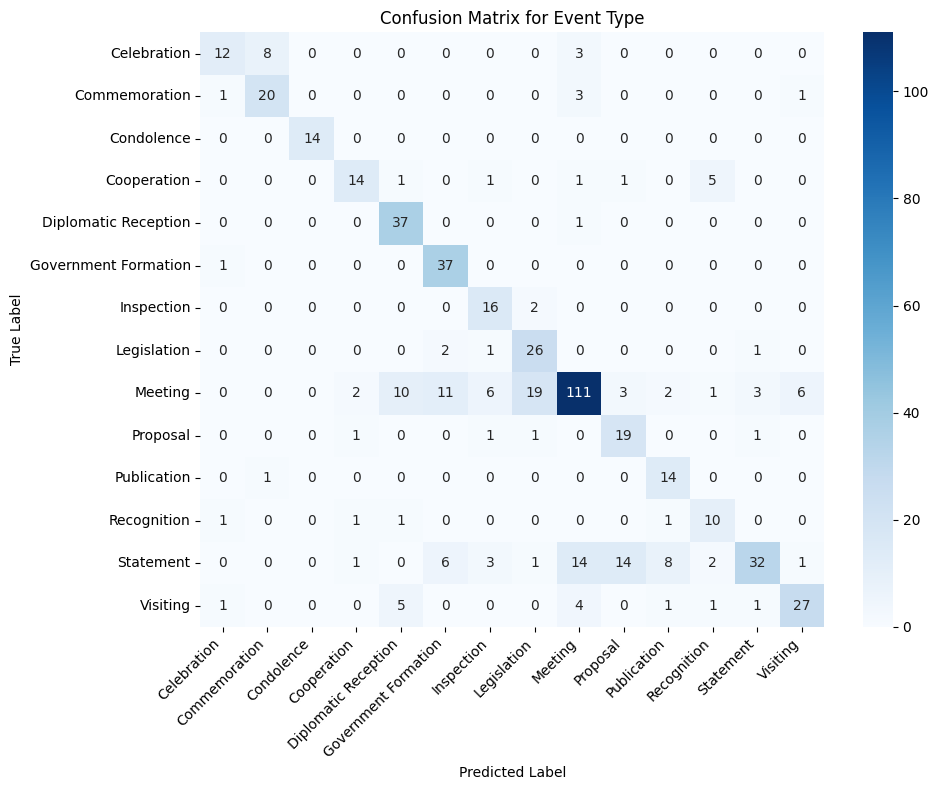


==================== Argument Extraction Evaluation ====================

Metrics are averaged across all successfully aligned records.

--- Average Scores for Extracted Arguments ---

Argument        | Avg BLEU   | Avg ROUGE-1  | Avg ROUGE-2  | Avg ROUGE-L 
----------------------------------------------------------------------
trigger         | 0.192      | 0.650        | 0.573        | 0.646       
arg_subject     | 0.678      | 0.847        | 0.814        | 0.843       
arg_time        | 0.275      | 0.906        | 0.652        | 0.904       
arg_location    | 0.331      | 0.826        | 0.386        | 0.823       


In [18]:
!pip install -q rouge-score nltk seaborn matplotlib

# Import libraries for evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import numpy as np

# --- Data Preparation for Evaluation ---

# Predictions are the successful results from the LLM
predictions = [r for r in labeled_results if 'error' not in r]
error_results = [r for r in labeled_results if 'error' in r]

print(f"LLM successfully processed: {len(predictions)}")
print(f"LLM failed to process: {len(error_results)}\n")

# Ground truth is the original data file, which you state is pre-labeled.
# We build a map using the stable 'id' as the key.
ground_truth_map = {record['id']: record for record in records_to_label}

# Align predictions with ground truth
y_true_event_type = []
y_pred_event_type = []
aligned_results = []

for pred_record in predictions:
    record_id = pred_record.get('id')
    
    # Check if the id from the prediction exists in our ground truth map
    if record_id in ground_truth_map:
        gt_record = ground_truth_map[record_id]
        
        # Robustness Check: Ensure the ground truth record actually has the required key.
        # This is the check that was failing before, proving the key was missing from the loaded data.
        if 'event_type' in gt_record and gt_record.get('event_type') is not None:
            y_true_event_type.append(gt_record['event_type'])
            y_pred_event_type.append(pred_record.get('event_type', 'N/A'))
            aligned_results.append({'pred': pred_record, 'gt': gt_record})
        else:
            # This will be printed if a record exists but lacks the label.
            print(f"Note: Skipping record with ID {record_id} because its ground truth entry is missing the 'event_type' label.")
    else:
        # This will be printed if the LLM hallucinates an ID that never existed.
        print(f"Warning: Could not find ground truth for a record with a predicted ID: {record_id}")

if aligned_results:
    print(f"\nEvaluating on {len(aligned_results)} records that have both a prediction and a ground truth label.\n")
    # --- Part 1: Event Type Classification Evaluation ---
    # ... (The rest of the evaluation code is correct and does not need to be changed) ...
    print("="*20 + " Event Type Classification Evaluation " + "="*20)
    
    all_labels = sorted(list(set(y_true_event_type + y_pred_event_type)))

    print("\n--- Classification Report (including F1-Score) ---\n")
    print(classification_report(y_true_event_type, y_pred_event_type, labels=all_labels, zero_division=0))

    print("\n--- Confusion Matrix ---\n")
    cm = confusion_matrix(y_true_event_type, y_pred_event_type, labels=all_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=all_labels, yticklabels=all_labels)
    plt.title('Confusion Matrix for Event Type')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # --- Part 2: Argument Extraction Evaluation (BLEU & ROUGE) ---
    print("\n" + "="*20 + " Argument Extraction Evaluation " + "="*20)
    print("\nMetrics are averaged across all successfully aligned records.")
    
    rouge_calc = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    chencherry = SmoothingFunction().method1 

    arg_scores = {
        'trigger': {'bleu': [], 'rouge1': [], 'rouge2': [], 'rougeL': []},
        'arg_subject': {'bleu': [], 'rouge1': [], 'rouge2': [], 'rougeL': []},
        'arg_time': {'bleu': [], 'rouge1': [], 'rouge2': [], 'rougeL': []},
        'arg_location': {'bleu': [], 'rouge1': [], 'rouge2': [], 'rougeL': []},
    }

    for item in aligned_results:
        gt = item['gt']
        pred = item['pred']
        
        for arg_name in arg_scores.keys():
            gt_text = gt.get(arg_name) or ""
            pred_text = pred.get(arg_name) or ""
            gt_tokens = [gt_text.split()]
            pred_tokens = pred_text.split()
            bleu_score = sentence_bleu(gt_tokens, pred_tokens, smoothing_function=chencherry)
            arg_scores[arg_name]['bleu'].append(bleu_score)
            rouge_results = rouge_calc.score(gt_text, pred_text)
            arg_scores[arg_name]['rouge1'].append(rouge_results['rouge1'].fmeasure)
            arg_scores[arg_name]['rouge2'].append(rouge_results['rouge2'].fmeasure)
            arg_scores[arg_name]['rougeL'].append(rouge_results['rougeL'].fmeasure)

    print("\n--- Average Scores for Extracted Arguments ---\n")
    print(f"{'Argument':<15} | {'Avg BLEU':<10} | {'Avg ROUGE-1':<12} | {'Avg ROUGE-2':<12} | {'Avg ROUGE-L':<12}")
    print("-" * 70)
    
    for arg_name, scores in arg_scores.items():
        avg_bleu = np.mean(scores['bleu'])
        avg_r1 = np.mean(scores['rouge1'])
        avg_r2 = np.mean(scores['rouge2'])
        avg_rL = np.mean(scores['rougeL'])
        print(f"{arg_name:<15} | {avg_bleu:<10.3f} | {avg_r1:<12.3f} | {avg_r2:<12.3f} | {avg_rL:<12.3f}")

else:
    print("No results could be aligned for evaluation. This is likely due to an issue with the ground truth file.")

In [19]:
output_filename = 'labeled_output.json'

with open(output_filename, 'w', encoding='utf-8') as f:
    json.dump(labeled_results, f, ensure_ascii=False, indent=4)

print(f"Successfully saved {len(labeled_results)} labeled records to '{output_filename}'.")

Successfully saved 557 labeled records to 'labeled_output.json'.


In [20]:
# # --- DIAGNOSTIC CELL: Inspect the structure of the loaded data ---

# print("--- Data Integrity Check on 'records_to_label' ---")

# if 'records_to_label' in locals() and records_to_label:
#     records_with_key = 0
#     records_without_key = 0
#     example_with_key = None
#     example_without_key = None

#     for record in records_to_label:
#         # We check for 'event_type' as it is the primary key for evaluation
#         if 'event_type' in record and record['event_type'] is not None:
#             records_with_key += 1
#             if example_with_key is None:
#                 example_with_key = record
#         else:
#             records_without_key += 1
#             if example_without_key is None:
#                 example_without_key = record

#     print(f"Total records loaded: {len(records_to_label)}")
#     print(f"Records containing a valid 'event_type' key: {records_with_key}")
#     print(f"Records MISSING a valid 'event_type' key: {records_without_key}")
#     print("-" * 30)

#     if example_without_key:
#         print("EXAMPLE OF A RECORD MISSING THE 'event_type' KEY:")
#         print(example_without_key)
#         print("-" * 30)

#     if example_with_key:
#         print("EXAMPLE OF A RECORD CONTAINING THE 'event_type' KEY:")
#         print(example_with_key)
    
#     if records_with_key == 0 and records_without_key > 0:
#         print("\n\n*** CONCLUSION: 100% of the loaded records are missing the 'event_type' key needed for evaluation. Please verify your input file. ***")
#     elif records_without_key > 0:
#         print("\n\n*** CONCLUSION: Your dataset is mixed. The evaluation is correctly skipping the records that lack a ground truth label. ***")
#     else:
#         print("\n\n*** CONCLUSION: All records contain the required key. The evaluation should proceed correctly with the code below. ***")

# else:
#     print("Variable 'records_to_label' not found or is empty. Check CELL 3.")